In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Team

Read NBA cluster data

In [8]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(1774, 116)

t-sne

In [9]:
nba_clustering_models = load_pickle('nba_clustering_models')
cluster_dict = nba_clustering_models['cluster_dict']

In [10]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%', 'Transition_Poss%']

In [11]:
labels = df['player_cluster'].values
X = df[poss_weights_cols].copy()
X_transformed = X.copy()
queues = ['pre_pca_pipe', 'pca', 'pre_cluster_scaler']
for step in queues:
    X_transformed = nba_clustering_models[step].transform(X_transformed)
tsne = TSNE(perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

key fuctions

In [12]:
cluster_dict_detail = {2: 'Ballhandler (Iso+PnR)', 1: 'Ballhandler (PnR)',
                       6: 'Big (Post Up+Roll)', 5: 'Big (Roll+Cut)',
                       0: 'Wing (Off Screen)', 4: 'Wing (Hand Off)', 
                       3: 'Wing (Spot Up+Transition)'}

In [13]:
def display_team_distribution(team, season=2021, 
                              df=df, cluster_dict=cluster_dict_detail):
    print(f'{season}-{str(season+1)[2:]} {team}')
    output = df[(df['team'] == team) & (df['season'] == season)].copy()
    cols = ['player', 'mp', 
            'usg_pct', 'ts_pct', 'Overall_PPP', 'obpm', 'dbpm', 'bpm',
            'player_cluster', 'player_cluster_discription']
    output['player_cluster_discription'] = output['player_cluster'].map(cluster_dict)
    return output[cols].sort_values('mp', ascending=False).reset_index().drop('index', axis=1)

In [14]:
def player_lookup(player, season=2021, df=df, if_ppp_n_rank=False):
    pdf = df[(df['Player'] == player) & (df['Season'] == season)]
    for idx in pdf.index:
        print(player, pdf.loc[idx]['Team'])
        print('-')
        for col in df.columns:
            if 'Poss%' in col and 'Miscellaneous' not in col:
                print(col, f'{pdf.loc[idx][col]:.2%}')
                if if_ppp_n_rank:
                    ppp_col = col.replace('Poss%', 'PPP')
                    print(ppp_col, f'{pdf.loc[idx][ppp_col]:.3f}')
                    rank_col = col.replace('Poss%', 'Rank')
                    print(rank_col, f'{pdf.loc[idx][rank_col]}')
                print('-')

In [15]:
def plot_players(lookup_idx, labels=labels, X_tsne=X_tsne, 
                 df=df, cluster_dict=cluster_dict):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
    plt.legend()
    plt.title('TSNE Visualization (Spectral Clustering based on 6 PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                     player_coord, alpha=0.6)

### Orlando Magic (#1)

- Point Diff: -8.5 (27th)
- Offense: 104.7 (30th)
- Defense: 113.1 (17th)

In [16]:
display_team_distribution('Orlando Magic')

2021-22 Orlando Magic


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Franz Wagner,2429,21.2,0.559,1.005,-0.4,-0.3,-0.7,1,Ballhandler (PnR)
1,Cole Anthony,2059,25.1,0.519,0.895,-0.6,-0.6,-1.2,1,Ballhandler (PnR)
2,Wendell Carter Jr.,1852,20.9,0.601,1.041,1.0,0.6,1.6,3,Wing (Spot Up+Transition)
3,Mo Bamba,1824,17.2,0.582,1.040,-0.2,0.9,0.7,3,Wing (Spot Up+Transition)
4,Chuma Okeke,1749,16.4,0.501,0.914,-1.6,1.5,-0.1,3,Wing (Spot Up+Transition)
5,Gary Harris,1730,16.4,0.571,1.038,-2.0,-0.4,-2.4,4,Wing (Hand Off)
6,Terrence Ross,1448,20.5,0.515,0.929,-2.5,-1.1,-3.7,4,Wing (Hand Off)
7,R.J. Hampton,1402,18.4,0.481,0.820,-4.0,-0.1,-4.1,3,Wing (Spot Up+Transition)
8,Jalen Suggs,1307,25.3,0.455,0.738,-5.3,-0.2,-5.6,1,Ballhandler (PnR)
9,Moritz Wagner,960,22.9,0.623,1.108,1.5,0.1,1.6,3,Wing (Spot Up+Transition)


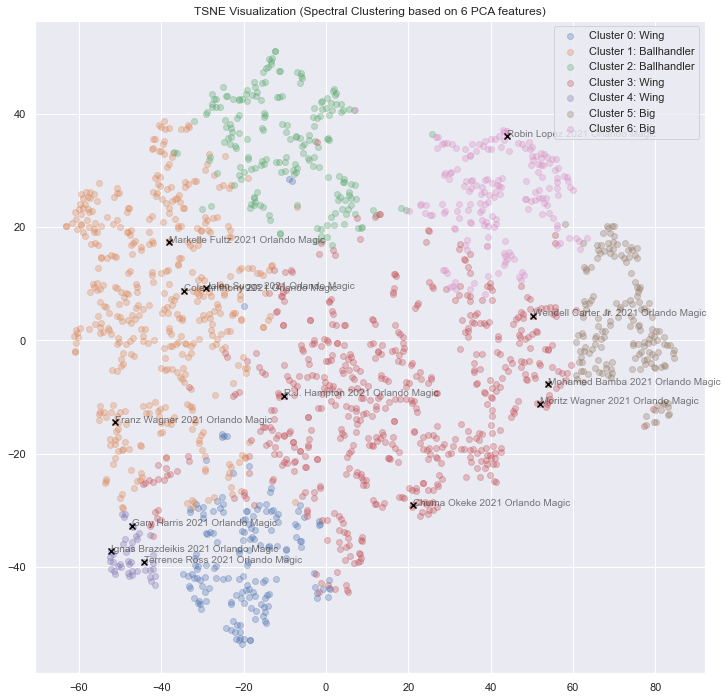

In [28]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Orlando Magic') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Oklahoma City Thunder (#2, 12)

- Point Diff: -8.6 (28th)
- Offense: 104.8 (29th)
- Defense: 113.4 (19th)

In [29]:
display_team_distribution('Oklahoma City Thunder')

2021-22 Oklahoma City Thunder


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Shai Gilgeous-Alexander,1942,30.8,0.557,0.992,2.9,0.5,3.4,2,Ballhandler (Iso+PnR)
1,Darius Bazley,1924,18.3,0.515,0.915,-2.1,0.3,-1.8,3,Wing (Spot Up+Transition)
2,Josh Giddey,1700,22.2,0.478,0.768,-1.2,0.3,-1.0,1,Ballhandler (PnR)
3,Luguentz Dort,1665,23.3,0.541,0.974,-1.5,-0.7,-2.3,3,Wing (Spot Up+Transition)
4,Tre Mann,1367,22.0,0.501,0.899,-3.3,-1.1,-4.3,1,Ballhandler (PnR)
5,Aleksej Pokusevski,1233,20.0,0.485,0.808,-2.7,0.1,-2.6,3,Wing (Spot Up+Transition)
6,Aaron Wiggins,1209,15.3,0.556,0.974,-3.4,-0.9,-4.3,3,Wing (Spot Up+Transition)
7,Jeremiah Robinson-Earl,1087,15.4,0.526,0.938,-1.9,-0.3,-2.2,3,Wing (Spot Up+Transition)
8,Kenrich Williams,1072,15.6,0.532,0.928,-1.3,1.1,-0.3,3,Wing (Spot Up+Transition)
9,Isaiah Roby,948,19.0,0.607,1.078,0.4,0.2,0.6,3,Wing (Spot Up+Transition)


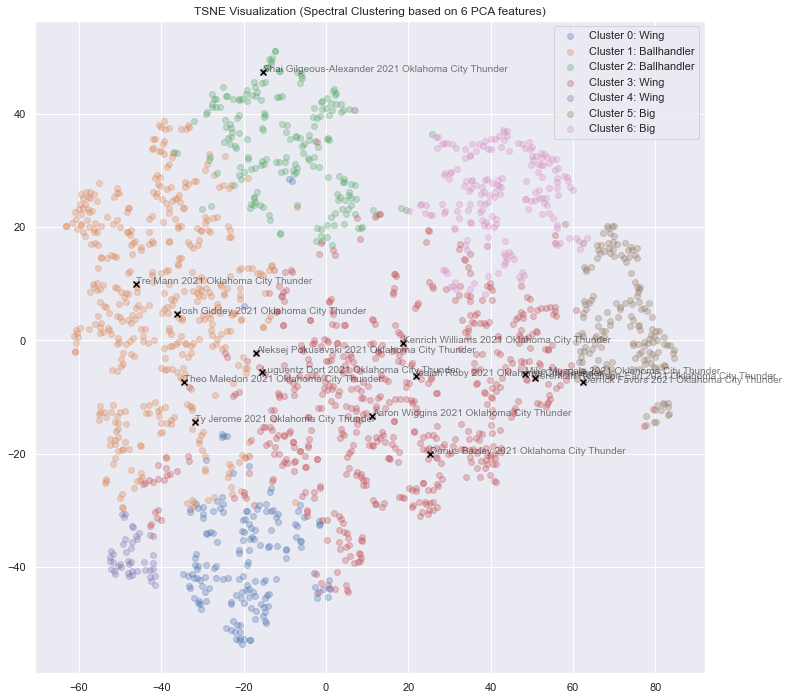

In [30]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Oklahoma City Thunder') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Houston Rockets (#3)

- Point Diff: -9.1 (30th)
- Offense: 108.7 (26th)
- Defense: 117.8 (30th)

In [31]:
display_team_distribution('Houston Rockets')

2021-22 Houston Rockets


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Jalen Green,2138,23.7,0.547,0.974,-0.5,-2.4,-2.9,1,Ballhandler (PnR)
1,Christian Wood,2094,23.3,0.595,1.054,2.1,-0.4,1.6,2,Ballhandler (Iso+PnR)
2,Jae'Sean Tate,2056,19.6,0.567,0.971,-1.3,-0.5,-1.8,3,Wing (Spot Up+Transition)
3,Kevin Porter Jr.,1907,24.1,0.531,0.878,-0.1,-1.6,-1.6,1,Ballhandler (PnR)
4,Garrison Mathews,1712,14.4,0.602,1.150,-1.3,-1.0,-2.3,4,Wing (Hand Off)
5,Eric Gordon,1669,18.6,0.614,1.051,-0.1,-2.2,-2.3,1,Ballhandler (PnR)
6,Kenyon Martin Jr.,1656,16.3,0.603,1.096,0.0,-1.2,-1.2,3,Wing (Spot Up+Transition)
7,Alperen Şengün,1489,22.0,0.552,0.891,-1.6,0.6,-1.0,6,Big (Post Up+Roll)
8,Josh Christopher,1334,21.1,0.534,0.879,-2.2,-1.3,-3.5,3,Wing (Spot Up+Transition)
9,Armoni Brooks,690,17.4,0.490,0.907,-2.6,-1.8,-4.4,4,Wing (Hand Off)


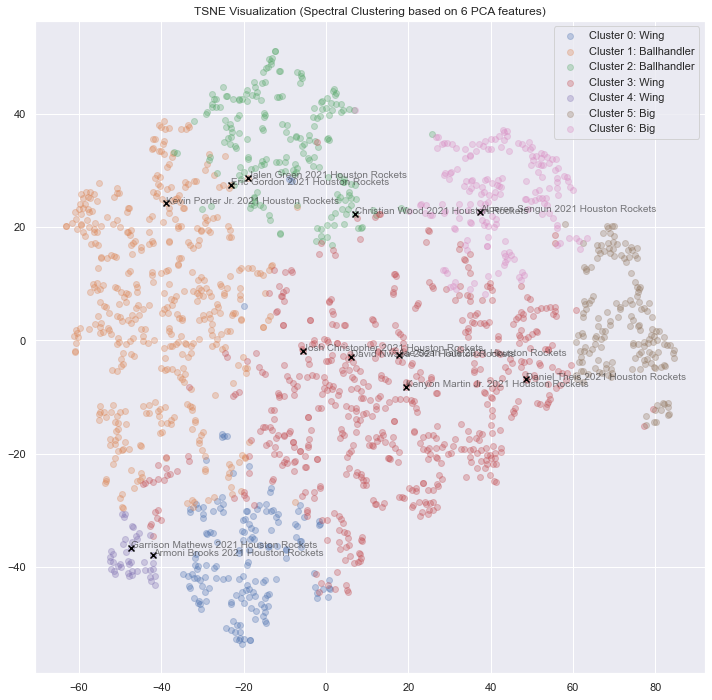

In [32]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Houston Rockets') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Sacramento Kings (#4)

- Point Diff: -5.9 (25th)
- Offense: 109.9 (25th)
- Defense: 115.8 (27th)

In [33]:
display_team_distribution('Sacramento Kings')

2021-22 Sacramento Kings


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Harrison Barnes,2587,18.8,0.623,1.125,1.5,-1.3,0.2,3,Wing (Spot Up+Transition)
1,De'Aaron Fox,2083,29.1,0.549,0.971,0.6,-1.2,-0.6,1,Ballhandler (PnR)
2,Davion Mitchell,2076,20.6,0.489,0.865,-2.1,-1.7,-3.8,1,Ballhandler (PnR)
3,Tyrese Haliburton,1757,18.3,0.575,0.982,2.2,0.4,2.6,1,Ballhandler (PnR)
4,Buddy Hield,1574,22.5,0.540,0.972,0.2,-1.5,-1.3,0,Wing (Off Screen)
5,Chimezie Metu,1279,18.5,0.546,0.967,-1.6,0.1,-1.5,3,Wing (Spot Up+Transition)
6,Richaun Holmes,1074,15.8,0.689,1.185,-0.4,-0.1,-0.5,5,Big (Roll+Cut)
7,Damian Jones,1017,16.2,0.701,1.192,-0.2,0.5,0.3,5,Big (Roll+Cut)
8,Maurice Harkless,863,11.2,0.561,0.964,-3.7,0.4,-3.3,3,Wing (Spot Up+Transition)
9,Donte DiVincenzo,665,18.5,0.532,0.902,-0.8,0.1,-0.6,1,Ballhandler (PnR)


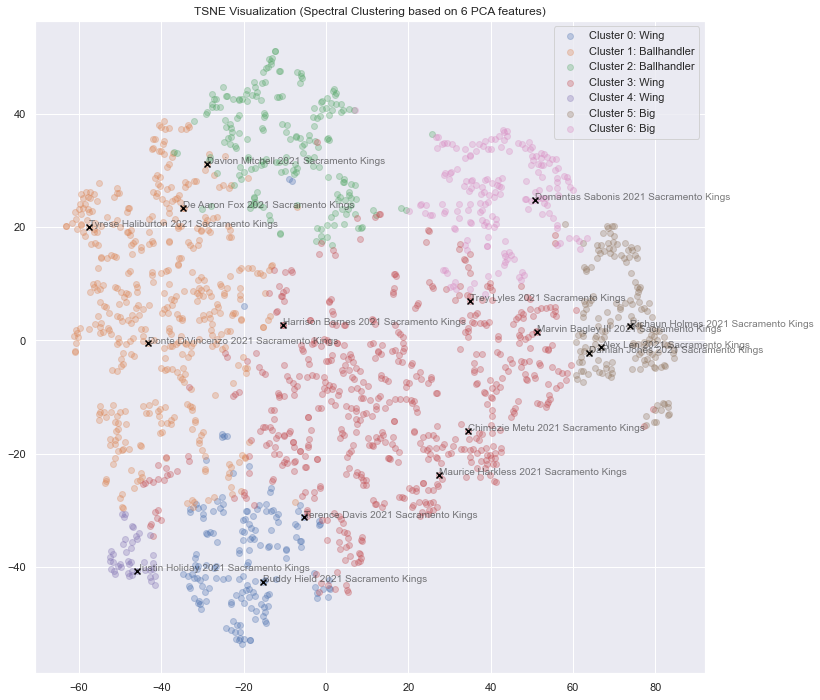

In [34]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Sacramento Kings') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Detroit Pistons (#5)

- Point Diff: -8.0 (26th)
- Offense: 106.2 (28th)
- Defense: 114.2 (23rd)

In [35]:
display_team_distribution('Detroit Pistons')

2021-22 Detroit Pistons


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Saddiq Bey,2704,21.3,0.529,0.984,0.9,-1.2,-0.3,2,Ballhandler (Iso+PnR)
1,Cade Cunningham,2088,27.5,0.504,0.833,-1.1,-0.5,-1.6,1,Ballhandler (PnR)
2,Isaiah Stewart,1816,14.6,0.550,0.952,-2.5,-0.8,-3.3,5,Big (Roll+Cut)
3,Killian Hayes,1647,15.7,0.461,0.750,-4.3,0.8,-3.5,1,Ballhandler (PnR)
4,Cory Joseph,1600,14.3,0.579,0.989,-2.0,-0.1,-2.1,1,Ballhandler (PnR)
5,Jerami Grant,1500,25.7,0.556,1.015,1.4,-0.2,1.2,2,Ballhandler (Iso+PnR)
6,Hamidou Diallo,1269,21.8,0.541,0.989,-1.2,0.7,-0.5,3,Wing (Spot Up+Transition)
7,Frank Jackson,1164,20.9,0.530,0.998,-1.8,-1.7,-3.5,0,Wing (Off Screen)
8,Trey Lyles,990,22.3,0.576,1.043,0.5,-0.4,0.0,3,Wing (Spot Up+Transition)
9,Kelly Olynyk,764,21.5,0.561,0.948,0.5,1.0,1.6,6,Big (Post Up+Roll)


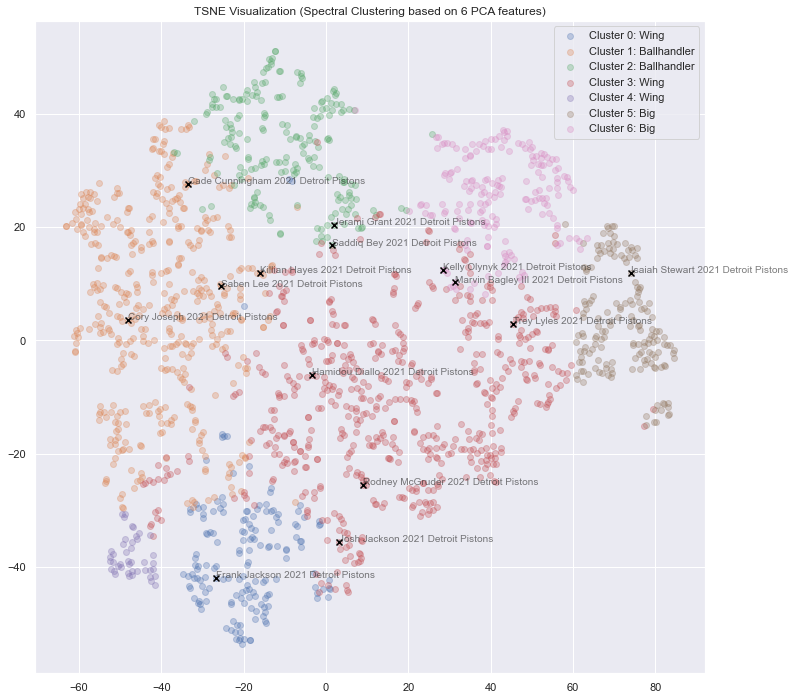

In [36]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Detroit Pistons') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Indiana Pacers (#6)

- Point Diff: -3.5 (22nd)
- Offense: 113.3 (15th)
- Defense: 116.8 (28th)

In [37]:
display_team_distribution('Indiana Pacers')

2021-22 Indiana Pacers


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Domantas Sabonis,1632,21.7,0.649,1.066,3.6,1.0,4.6,6,Big (Post Up+Roll)
1,Oshae Brissett,1564,17.3,0.530,0.970,-0.5,-1.7,-2.2,3,Wing (Spot Up+Transition)
2,Chris Duarte,1541,21.1,0.537,0.949,-1.2,-1.1,-2.3,3,Wing (Spot Up+Transition)
3,Justin Holiday,1416,15.9,0.568,1.030,-0.8,-0.8,-1.7,4,Wing (Hand Off)
4,Myles Turner,1235,17.1,0.615,1.098,0.1,1.4,1.4,3,Wing (Spot Up+Transition)
5,Caris LeVert,1214,26.8,0.530,0.957,1.0,-1.3,-0.3,1,Ballhandler (PnR)
6,Malcolm Brogdon,1206,24.6,0.557,0.999,2.8,-0.5,2.3,1,Ballhandler (PnR)
7,Torrey Craig,1034,13.9,0.555,0.982,-1.6,-0.6,-2.2,3,Wing (Spot Up+Transition)
8,Duane Washington Jr.,968,22.6,0.521,0.924,-1.9,-2.8,-4.8,3,Wing (Spot Up+Transition)
9,Tyrese Haliburton,938,20.3,0.629,1.018,3.7,-1.0,2.8,1,Ballhandler (PnR)


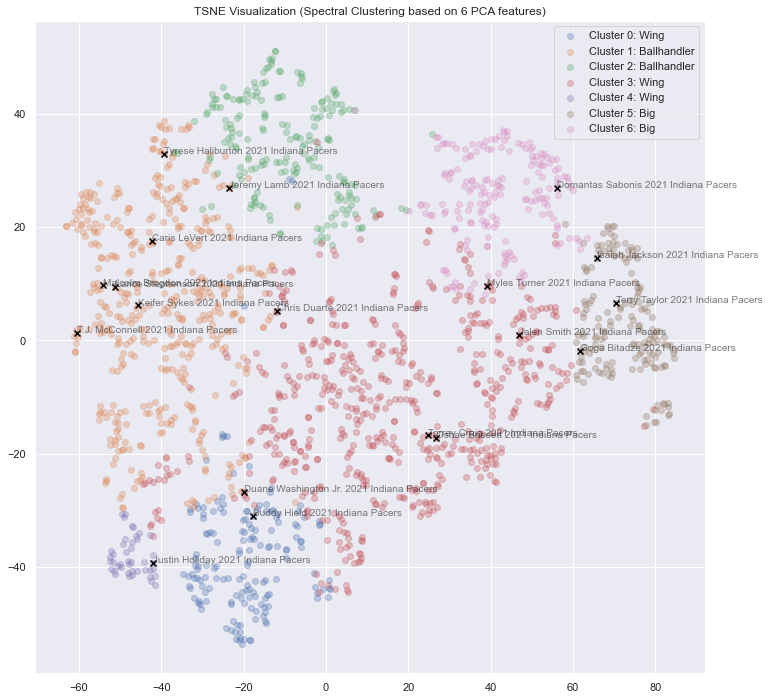

In [38]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Indiana Pacers') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Portland Trail Blazers (#7)

- Point Diff: -8.7 (29th)
- Offense: 108.5 (27th)
- Defense: 117.2 (29th)

In [39]:
display_team_distribution('Portland Trail Blazers')

2021-22 Portland Trail Blazers


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Anfernee Simons,1681,24.8,0.583,1.033,1.9,-2.7,-0.7,2,Ballhandler (Iso+PnR)
1,Jusuf Nurkić,1579,23.6,0.586,0.977,0.1,0.2,0.3,6,Big (Post Up+Roll)
2,Robert Covington,1431,12.4,0.519,0.888,-2.9,1.6,-1.3,3,Wing (Spot Up+Transition)
3,Norman Powell,1333,22.5,0.593,1.081,0.6,-1.6,-1.0,3,Wing (Spot Up+Transition)
4,Ben McLemore,1285,21.3,0.567,1.040,-0.7,-2.5,-3.2,0,Wing (Off Screen)
5,CJ McCollum,1267,26.1,0.532,0.969,1.8,-1.7,0.1,2,Ballhandler (Iso+PnR)
6,CJ Elleby,1174,14.8,0.491,0.845,-3.8,-1.5,-5.3,3,Wing (Spot Up+Transition)
7,Nassir Little,1088,15.8,0.575,1.038,-0.9,-0.6,-1.5,3,Wing (Spot Up+Transition)
8,Damian Lillard,1056,29.3,0.550,0.976,4.0,-2.7,1.3,2,Ballhandler (Iso+PnR)
9,Trendon Watford,869,17.6,0.590,1.028,-1.4,-0.4,-1.7,3,Wing (Spot Up+Transition)


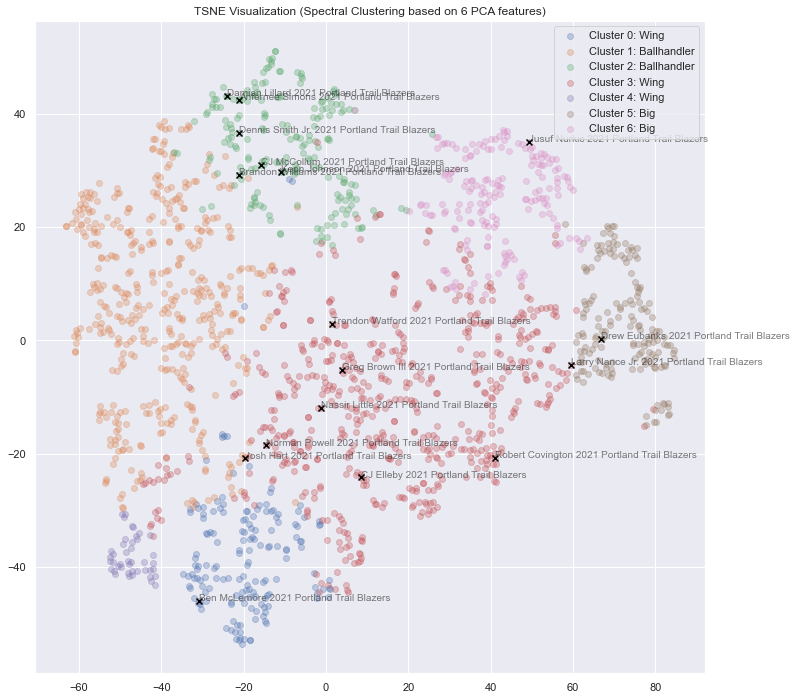

In [40]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Portland Trail Blazers') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### New Orleans Pelicans (#8)

- Point Diff: -2.2 (21st)
- Offense: 111.1 (20th)
- Defense: 113.2 (18th)

In [41]:
display_team_distribution('New Orleans Pelicans')

2021-22 New Orleans Pelicans


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Herbert Jones,2335,13.7,0.573,0.993,-2.0,1.5,-0.5,3,Wing (Spot Up+Transition)
1,Jonas Valančiūnas,2240,23.8,0.617,1.055,2.0,-0.1,1.9,6,Big (Post Up+Roll)
2,Devonte' Graham,2162,19.5,0.514,0.927,0.2,-1.2,-1.0,1,Ballhandler (PnR)
3,Brandon Ingram,1869,29.3,0.554,0.983,2.6,-0.6,2.0,2,Ballhandler (Iso+PnR)
4,Jaxson Hayes,1398,16.4,0.680,1.232,0.6,-0.3,0.2,5,Big (Roll+Cut)
5,Josh Hart,1374,16.7,0.604,1.015,-0.2,0.9,0.7,3,Wing (Spot Up+Transition)
6,Nickeil Alexander-Walker,1317,24.8,0.474,0.841,-1.7,-1.3,-3.0,1,Ballhandler (PnR)
7,Garrett Temple,1098,13.9,0.494,0.868,-2.8,0.3,-2.5,3,Wing (Spot Up+Transition)
8,CJ McCollum,878,29.4,0.580,1.059,5.3,-0.7,4.6,1,Ballhandler (PnR)
9,Trey Murphy III,864,15.7,0.558,1.071,0.2,-1.4,-1.2,3,Wing (Spot Up+Transition)


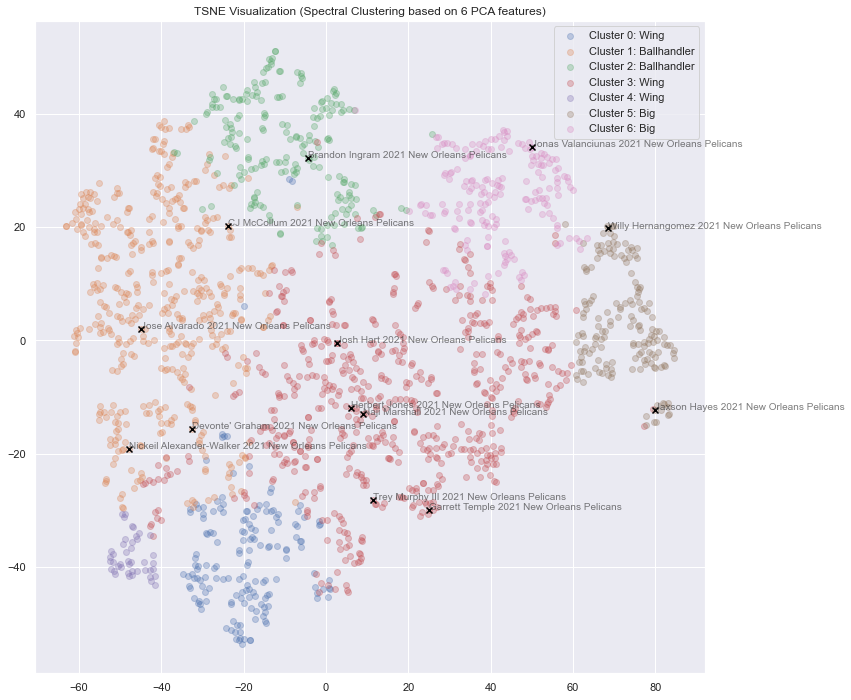

In [42]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'New Orleans Pelicans') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### San Antonio Spurs (#9)

- Point Diff: -0.3 (20th)
- Offense: 112.6 (18th)
- Defense: 112.9 (16th)

In [43]:
display_team_distribution('San Antonio Spurs')

2021-22 San Antonio Spurs


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Keldon Johnson,2392,21.3,0.574,1.061,0.7,-1.2,-0.5,3,Wing (Spot Up+Transition)
1,Dejounte Murray,2366,27.3,0.533,0.943,3.7,1.7,5.4,1,Ballhandler (PnR)
2,Jakob Poeltl,1970,18.3,0.613,1.071,0.9,0.7,1.6,5,Big (Roll+Cut)
3,Devin Vassell,1937,18.9,0.540,1.010,-0.5,0.0,-0.5,3,Wing (Spot Up+Transition)
4,Lonnie Walker IV,1612,23.6,0.512,0.940,-1.2,-1.3,-2.5,3,Wing (Spot Up+Transition)
5,Derrick White,1486,20.7,0.551,0.974,1.2,0.6,1.8,1,Ballhandler (PnR)
6,Doug McDermott,1223,18.3,0.593,1.095,-0.4,-2.1,-2.5,0,Wing (Off Screen)
7,Tre Jones,1148,15.6,0.545,0.976,-0.9,0.4,-0.5,1,Ballhandler (PnR)
8,Joshua Primo,965,15.4,0.487,0.814,-3.9,-1.1,-5.0,3,Wing (Spot Up+Transition)
9,Keita Bates-Diop,956,14.8,0.578,1.000,-2.1,-0.5,-2.6,3,Wing (Spot Up+Transition)


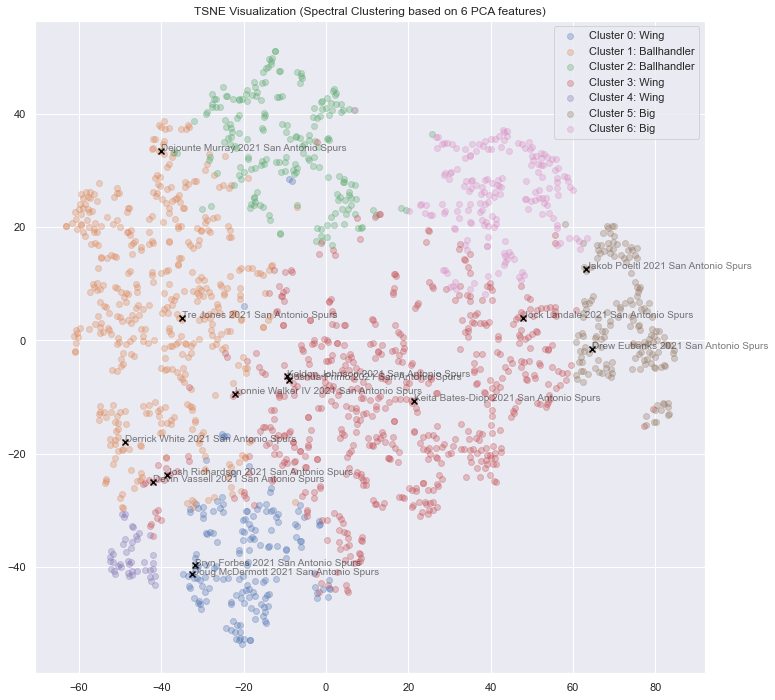

In [44]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'San Antonio Spurs') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Washington Wizards (#10)

- Point Diff: -3.8 (24th)
- Offense: 110.9 (22nd)
- Defense: 114.7 (25th)

In [45]:
display_team_distribution('Washington Wizards')

2021-22 Washington Wizards


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Kentavious Caldwell-Pope,2329,19.0,0.568,1.030,-0.9,-0.6,-1.5,0,Wing (Off Screen)
1,Kyle Kuzma,2204,24.2,0.547,0.941,0.2,-0.4,-0.2,2,Ballhandler (Iso+PnR)
2,Deni Avdija,1984,16.3,0.536,0.942,-2.1,0.4,-1.7,3,Wing (Spot Up+Transition)
3,Corey Kispert,1801,14.6,0.586,1.075,-0.8,-1.5,-2.3,3,Wing (Spot Up+Transition)
4,Daniel Gafford,1444,16.7,0.708,1.258,1.1,0.5,1.6,5,Big (Roll+Cut)
5,Bradley Beal,1439,30.8,0.539,0.936,2.0,-1.2,0.8,2,Ballhandler (Iso+PnR)
6,Raul Neto,1372,18.4,0.538,0.928,-2.5,-0.5,-3.0,1,Ballhandler (PnR)
7,Spencer Dinwiddie,1330,21.0,0.501,0.888,-0.3,-0.7,-0.9,2,Ballhandler (Iso+PnR)
8,Montrezl Harrell,1117,20.8,0.684,1.239,4.3,0.6,4.8,6,Big (Post Up+Roll)
9,Rui Hachimura,943,20.9,0.579,1.075,0.2,-1.7,-1.5,3,Wing (Spot Up+Transition)


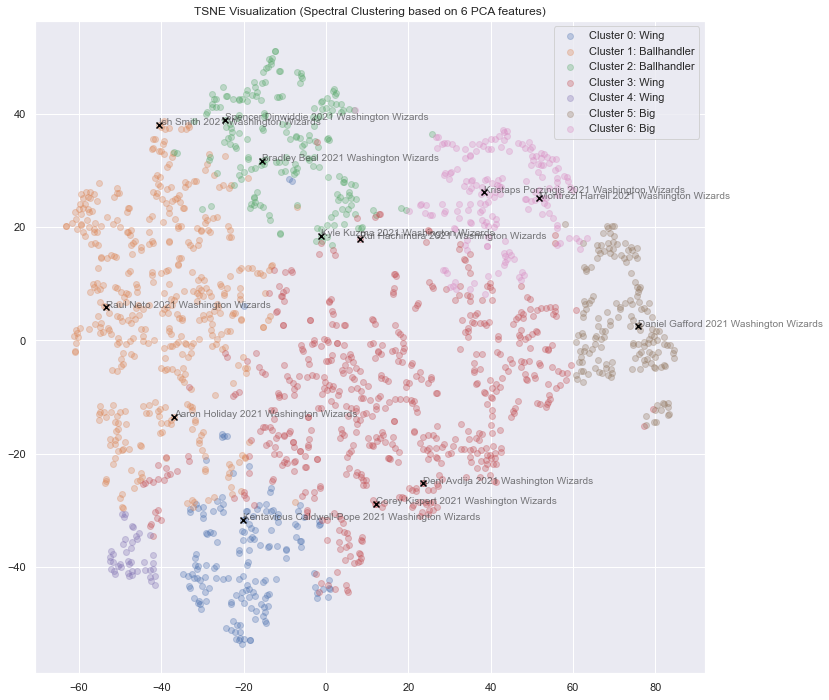

In [46]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Washington Wizards') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### New York Knicks (#11)

- Point Diff: -0.1 (18th)
- Offense: 110.9 (21st)
- Defense: 111.0 (12th)

In [47]:
display_team_distribution('New York Knicks')

2021-22 New York Knicks


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Julius Randle,2544,28.7,0.509,0.868,0.4,0.2,0.5,2,Ballhandler (Iso+PnR)
1,RJ Barrett,2417,27.6,0.511,0.917,-0.3,-1.3,-1.6,1,Ballhandler (PnR)
2,Evan Fournier,2358,20.8,0.554,1.012,-0.4,-0.3,-0.7,3,Wing (Spot Up+Transition)
3,Alec Burks,2318,17.7,0.559,1.017,-0.4,1.2,0.8,1,Ballhandler (PnR)
4,Mitchell Robinson,1848,11.4,0.722,1.260,1.0,1.2,2.2,5,Big (Roll+Cut)
5,Immanuel Quickley,1802,22.2,0.543,0.976,0.2,0.0,0.2,2,Ballhandler (Iso+PnR)
6,Obi Toppin,1230,20.8,0.614,1.110,1.7,0.3,2.0,3,Wing (Spot Up+Transition)
7,Kemba Walker,948,20.8,0.537,0.966,0.7,-0.2,0.4,1,Ballhandler (PnR)
8,Quentin Grimes,786,15.1,0.565,1.015,-1.2,0.9,-0.3,3,Wing (Spot Up+Transition)
9,Derrick Rose,636,22.5,0.541,0.951,2.3,0.0,2.3,1,Ballhandler (PnR)


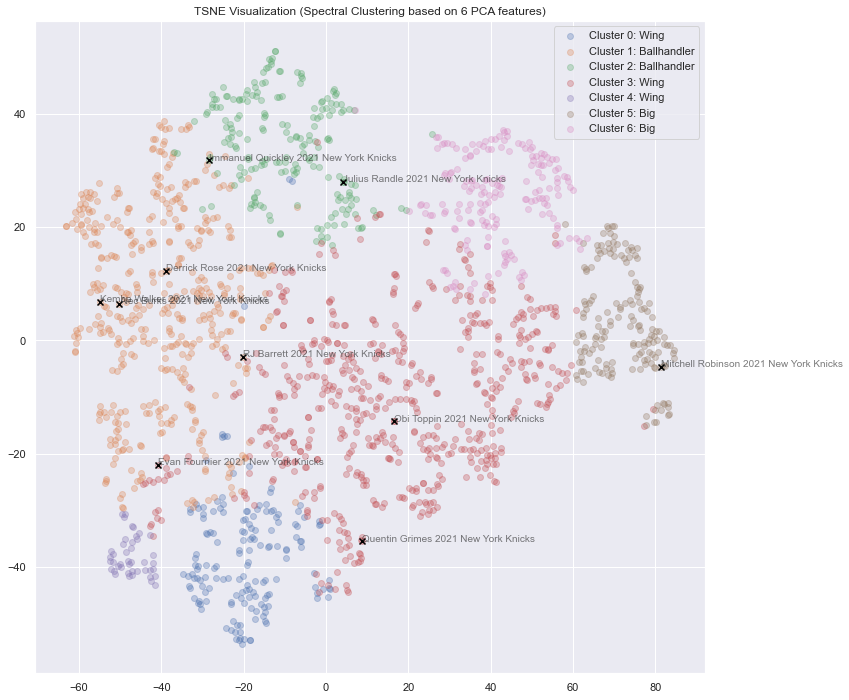

In [48]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'New York Knicks') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Charlotte Hornets (#13, 15)

- Point Diff: +1.2 (15th)
- Offense: 114.8 (6th)
- Defense: 113.6 (20th)

In [49]:
display_team_distribution('Charlotte Hornets')

2021-22 Charlotte Hornets


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Miles Bridges,2837,22.6,0.593,1.069,1.8,-0.3,1.5,2,Ballhandler (Iso+PnR)
1,Terry Rozier,2458,23.2,0.566,1.062,2.4,-0.7,1.7,0,Wing (Off Screen)
2,LaMelo Ball,2422,28.2,0.554,0.944,3.3,0.2,3.4,1,Ballhandler (PnR)
3,Kelly Oubre Jr.,1999,23.0,0.560,1.055,0.2,-1.6,-1.4,3,Wing (Spot Up+Transition)
4,Cody Martin,1866,12.1,0.579,1.026,-1.2,0.7,-0.5,3,Wing (Spot Up+Transition)
5,Mason Plumlee,1793,11.7,0.603,0.954,-1.5,1.5,0.0,5,Big (Roll+Cut)
6,P.J. Washington,1768,15.6,0.588,1.026,-0.2,0.2,-0.1,3,Wing (Spot Up+Transition)
7,Gordon Hayward,1564,20.7,0.570,1.020,0.1,-0.8,-0.7,3,Wing (Spot Up+Transition)
8,Jalen McDaniels,895,15.3,0.595,1.049,-1.9,-0.4,-2.3,3,Wing (Spot Up+Transition)
9,Montrezl Harrell,524,19.0,0.672,1.228,2.6,-0.8,1.8,6,Big (Post Up+Roll)


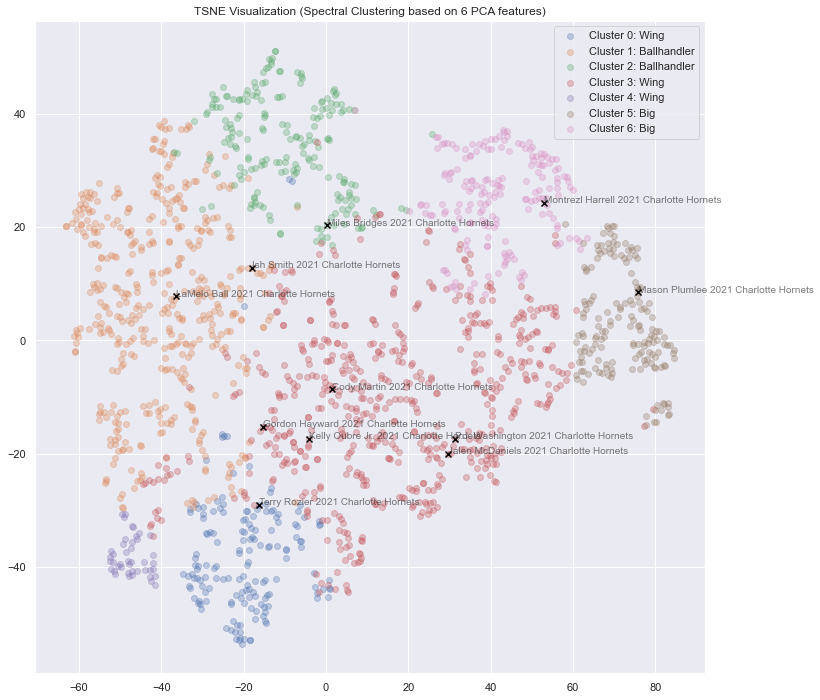

In [50]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Charlotte Hornets') & (df['season'] == 2021)].index
plot_players(lookup_idx)

### Cleveland Cavaliers (#14)

- Point Diff: +1.9 (13th)
- Offense: 111.8 (19th)
- Defense: 110.0 (6th)

In [51]:
display_team_distribution('Cleveland Cavaliers')

2021-22 Cleveland Cavaliers


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,player_cluster_discription
0,Darius Garland,2430,27.8,0.576,0.974,3.4,-0.8,2.6,1,Ballhandler (PnR)
1,Evan Mobley,2331,20.4,0.549,0.963,-0.9,1.5,0.6,3,Wing (Spot Up+Transition)
2,Isaac Okoro,1981,12.4,0.589,1.050,-2.4,0.7,-1.7,3,Wing (Spot Up+Transition)
3,Lauri Markkanen,1878,19.5,0.582,1.087,0.4,-0.1,0.4,3,Wing (Spot Up+Transition)
4,Jarrett Allen,1809,18.1,0.698,1.212,2.7,1.2,3.9,5,Big (Roll+Cut)
5,Kevin Love,1665,25.1,0.594,1.068,4.3,0.1,4.5,6,Big (Post Up+Roll)
6,Cedi Osman,1462,21.1,0.563,1.014,-0.3,0.5,0.2,3,Wing (Spot Up+Transition)
7,Lamar Stevens,1015,17.1,0.544,0.980,-3.2,0.3,-2.9,3,Wing (Spot Up+Transition)
8,Dean Wade,980,11.1,0.584,1.102,-1.9,1.3,-0.6,3,Wing (Spot Up+Transition)
9,Ricky Rubio,970,24.9,0.488,0.818,-1.0,1.2,0.2,1,Ballhandler (PnR)


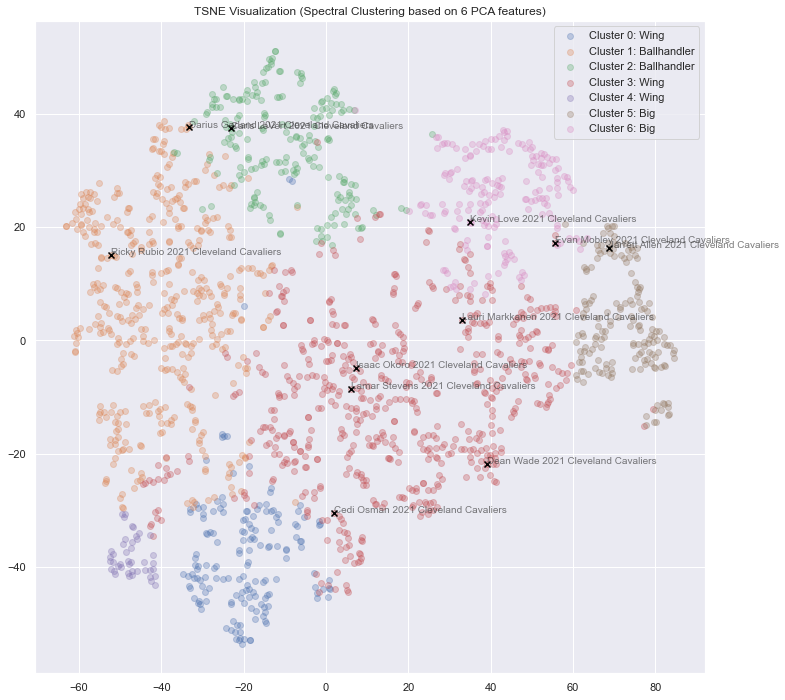

In [52]:
figsize(12, 12)
lookup_idx = df[(df['team'] == 'Cleveland Cavaliers') & (df['season'] == 2021)].index
plot_players(lookup_idx)

## Player

Read NCAA data

In [53]:
ncaa_df = pd.read_csv('ncaa_offense.csv')
ncaa_df['Player'] = ncaa_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
ncaa_df['Overall_Poss'] = ncaa_df['Overall_Poss'] - ncaa_df['Miscellaneous_Poss']
ncaa_df = ncaa_df[ncaa_df['Overall_Poss'] >= 70]
ncaa_df.shape

(18567, 74)

Read kmeans models

In [54]:
nba_clustering_models_km = load_pickle('nba_clustering_models_km')
pre_pca_pipe = nba_clustering_models_km['pre_pca_pipe']
pca = nba_clustering_models_km['pca']
pre_cluster_scaler = nba_clustering_models_km['pre_cluster_scaler']
cluster_map_km_to_sc = nba_clustering_models_km['cluster_map_to_spectral_clustering']
km = nba_clustering_models_km['km']

Assign cluster

In [55]:
for col in poss_weights_cols:
    ncaa_df[col] = ncaa_df[col.replace('%', '')] / ncaa_df['Overall_Poss']
    ncaa_df[col] = ncaa_df[col].fillna(0)

In [56]:
X = ncaa_df[poss_weights_cols].copy()
X_transformed = pre_cluster_scaler.transform(pca.transform(pre_pca_pipe.transform(X)))
ncaa_df['player_cluster'] = km.predict(X_transformed)
ncaa_df['player_cluster'] = ncaa_df['player_cluster'].map(cluster_map_km_to_sc)
ncaa_df['player_cluster_discription'] = ncaa_df['player_cluster'].map(cluster_dict_detail)

key functions

In [57]:
def display_draft(l, season, ncaa_df=ncaa_df):
    display_cols = ['Player', 'Overall_Poss', 'Overall_PPP', 'Overall_Rank', 
                    'Team', 'Season', 'player_cluster', 'player_cluster_discription']
    class_df = ncaa_df[(ncaa_df['Player'].isin(l)) & (ncaa_df['Season'] == season)]
    class_df['Player'] = class_df['Player'].astype('category')
    class_df['Player'].cat.set_categories(l, inplace=True)
    return class_df.sort_values('Player')[display_cols]

In [58]:
def display_playtype(playtype, l, season, ncaa_df=ncaa_df):
    pt_bh_cols = ['Player','Team', 'Season',
                  f'{playtype}_Poss%', f'{playtype}_PPP',
                  'player_cluster_discription']
    output = ncaa_df[(ncaa_df['Player'].isin(l)) &
                     (ncaa_df[f'{playtype}_Poss%'] > 0.1) &
                     (ncaa_df['Season'] == season)]
    return output.sort_values(f'{playtype}_PPP', 
                              ascending=False)[pt_bh_cols]

### 2022 Green Room

In [59]:
# green_room = ['Chet Holmgren', 'Jabari Smith', 'Paolo Banchero', 
#               'Jaden Ivey', 'Keegan Murray', 'BennedictMathurin',
#               'AJ Griffin', 'Jalen Duren', 'Jonathan Davis',
#               'Jeremy Sochan', 'Ochai Agbaji', 'Mark Williams', 
#               'Malaki Branham', 'Tari Eason', 'TyTy Washington Jr.',
#               'Jalen Williams', 'Blake Wesley']

In [60]:
first_rounder_22 = ['Paolo Banchero', 'Chet Holmgren', 'Jabari Smith',
                    'Keegan Murray', 'Jaden Ivey', 'BennedictMathurin',
                    'Jeremy Sochan', 'Jonathan Davis', 'Jalen Williams',
                    'Jalen Duren', 'Ochai Agbaji', 'Mark Williams', 
                    'AJ Griffin', 'Tari Eason', 'DalenTerry',
                    'Jake Laravia', 'Malaki Branham', 'Christian Braun',
                    'Walker Kessler', 'David Roddy', 'Blake Wesley',
                    'Wendell Moore Jr.', 'Patrick Baldwin Jr.', 'TyTy Washington Jr.',
                    'Peyton Watson']

In [61]:
second_rounder_22 = ['Andrew Nembhard', 'Caleb Houstan', 'Christian Koloko', 
                     'Jaylin Williams', 'Max Christie', 'Kennedy Chandler',
                     'Bryce Mcgowens', 'E.J.Liddell', 'Trevor Keels', 
                     'Moussa Diabate', 'Ryan Rollins', 'Josh Minott', 
                     'Vince Williams', 'Kendall Brown', 'Isaiah Mobley',
                     'Tyrese Martin', 'JD Davison', 'Jabari Walker']

In [62]:
display_draft(first_rounder_22, 2021)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
28983,Paolo Banchero,656.0,0.964,75,Duke Blue Devils,2021,2,Ballhandler (Iso+PnR)
26293,Chet Holmgren,355.0,1.165,98,Gonzaga Bulldogs,2021,3,Wing (Spot Up+Transition)
25350,Jabari Smith,513.0,1.014,85,Auburn Tigers,2021,2,Ballhandler (Iso+PnR)
25136,Keegan Murray,654.0,1.213,99,Iowa Hawkeyes,2021,0,Wing (Off Screen)
25873,Jaden Ivey,583.0,0.973,77,Purdue Boilermakers,2021,1,Ballhandler (PnR)
24975,BennedictMathurin,586.0,1.023,86,Arizona Wildcats,2021,1,Ballhandler (PnR)
24808,Jeremy Sochan,276.0,0.927,65,Baylor Bears,2021,3,Wing (Spot Up+Transition)
24892,Jonathan Davis,624.0,0.924,65,Wisconsin Badgers,2021,1,Ballhandler (PnR)
25716,Jalen Williams,534.0,1.050,90,Santa Clara Broncos,2021,1,Ballhandler (PnR)
28121,Jalen Duren,309.0,1.018,86,Memphis Tigers,2021,6,Big (Post Up+Roll)


In [63]:
display_draft(second_rounder_22, 2021)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
26292,Andrew Nembhard,378.0,0.945,70,Gonzaga Bulldogs,2021,1,Ballhandler (PnR)
25112,Caleb Houstan,349.0,0.932,67,Michigan Wolverines,2021,0,Wing (Off Screen)
24977,Christian Koloko,363.0,1.150,97,Arizona Wildcats,2021,6,Big (Post Up+Roll)
26749,Jaylin Williams,392.0,0.913,61,Arkansas Razorbacks,2021,6,Big (Post Up+Roll)
25355,Jaylin Williams,174.0,0.964,75,Auburn Tigers,2021,3,Wing (Spot Up+Transition)
27565,Max Christie,358.0,0.859,46,Michigan State Spartans,2021,0,Wing (Off Screen)
28431,Kennedy Chandler,502.0,0.896,56,Tennessee Volunteers,2021,2,Ballhandler (Iso+PnR)
24922,Bryce Mcgowens,527.0,0.936,68,Nebraska Cornhuskers,2021,2,Ballhandler (Iso+PnR)
24245,E.J.Liddell,544.0,1.034,88,Ohio State Buckeyes,2021,6,Big (Post Up+Roll)
28985,Trevor Keels,425.0,0.919,63,Duke Blue Devils,2021,3,Wing (Spot Up+Transition)


In [64]:
display_playtype('P&R Ball Handler', first_rounder_22, season=2021)

,Player,Team,Season,P&R Ball Handler_Poss%,P&R Ball Handler_PPP,player_cluster_discription
24246,Malaki Branham,Ohio State Buckeyes,2021,0.287879,1.044,Ballhandler (PnR)
25716,Jalen Williams,Santa Clara Broncos,2021,0.391386,0.943,Ballhandler (PnR)
25873,Jaden Ivey,Purdue Boilermakers,2021,0.296741,0.919,Ballhandler (PnR)
26571,Christian Braun,Kansas Jayhawks,2021,0.100971,0.904,Wing (Spot Up+Transition)
24892,Jonathan Davis,Wisconsin Badgers,2021,0.309295,0.876,Ballhandler (PnR)
28984,Wendell Moore Jr.,Duke Blue Devils,2021,0.164905,0.872,Wing (Spot Up+Transition)
26570,Ochai Agbaji,Kansas Jayhawks,2021,0.133956,0.791,Wing (Off Screen)
24975,BennedictMathurin,Arizona Wildcats,2021,0.228669,0.776,Ballhandler (PnR)
28490,TyTy Washington Jr.,Kentucky Wildcats,2021,0.194373,0.737,Wing (Spot Up+Transition)
28164,Blake Wesley,Notre Dame Fighting Irish,2021,0.373866,0.699,Ballhandler (PnR)


In [65]:
# player_lookup('Ziaire Williams', season=2021, if_ppp_n_rank=True)

In [66]:
# player_lookup('Jonathan Davis', df=ncaa_df, season=2021, if_ppp_n_rank=True)

In [76]:
playtype = 'P&R Ball Handler'
pd.concat([display_playtype(playtype, first_rounder_22, season=2021),
           display_playtype(playtype, first_rounder_21, season=2020),
           display_playtype(playtype, first_rounder_20, season=2019),
           display_playtype(playtype, first_rounder_19, season=2018),
           display_playtype(playtype, first_rounder_18, season=2017)])\
.sort_values(f'{playtype}_PPP', ascending=False).head(20)

,Player,Team,Season,P&R Ball Handler_Poss%,P&R Ball Handler_PPP,player_cluster_discription
8776,Donte DiVincenzo,Villanova Wildcats,2017,0.138655,1.106,Wing (Spot Up+Transition)
20145,Cameron Thomas,LSU Tigers,2020,0.150573,1.076,Ballhandler (Iso+PnR)
18251,Malachi Flynn,San Diego State Aztecs,2019,0.428287,1.060,Ballhandler (PnR)
8107,Miles Bridges,Michigan State Spartans,2017,0.104317,1.052,Wing (Off Screen)
24246,Malaki Branham,Ohio State Buckeyes,2021,0.287879,1.044,Ballhandler (PnR)
21652,Chris Duarte,Oregon Ducks,2020,0.192935,1.042,Ballhandler (Iso+PnR)
9198,Jerome Robinson,Boston College Eagles,2017,0.148773,1.041,Wing (Off Screen)
10019,Darius Garland,Vanderbilt Commodores,2018,0.569444,1.000,Ballhandler (PnR)
10586,Romeo Langford,Indiana Hoosiers,2018,0.274809,0.993,Ballhandler (PnR)
8775,Mikal Bridges,Villanova Wildcats,2017,0.111314,0.984,Wing (Spot Up+Transition)


### 2021 First Round

In [68]:
first_rounder_21 = ['Cade Cunningham', 'Evan Mobley', 'Scottie Barnes',
                    'Jalen Suggs', 'FranzWagner', 'Davion Mitchell',
                    'Zaire Williams', 'JamesBouknight', 'Joshua Primo',
                    'Chris Duarte', 'Moses Moody', 'Corey Kispert',
                    'Trey Murphy III', 'Tre Mann', 'Kai Jones',
                    'Jalen Johnson', 'Keon Johnson', 'Isaiah Jackson',
                    'JoshChristopher', 'QuentinGrimes', "Nah'Shon Hyland", 
                    'Cameron Thomas', 'Jaden Springer', "Day'Ron Sharpe",
                    'Santi Aldama']

In [69]:
drop_list_21 = [22771, 22004, 22841]
display_draft(first_rounder_21, 2020).drop(index=drop_list_21)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
22780,Cade Cunningham,541.0,0.930,66,Oklahoma State Cowboys,2020,2,Ballhandler (Iso+PnR)
21775,Evan Mobley,477.0,1.063,91,USC Trojans,2020,6,Big (Post Up+Roll)
23088,Scottie Barnes,258.0,0.876,51,Florida State Seminoles,2020,1,Ballhandler (PnR)
21348,Jalen Suggs,420.0,0.958,73,Gonzaga Bulldogs,2020,1,Ballhandler (PnR)
20188,FranzWagner,316.0,1.039,88,Michigan Wolverines,2020,1,Ballhandler (PnR)
19913,Davion Mitchell,394.0,1.025,86,Baylor Bears,2020,2,Ballhandler (Iso+PnR)
19837,Zaire Williams,264.0,0.739,23,Stanford Cardinal,2020,1,Ballhandler (PnR)
23117,JamesBouknight,280.0,0.938,68,Connecticut Huskies,2020,0,Wing (Off Screen)
23029,Joshua Primo,241.0,0.945,70,Alabama Crimson Tide,2020,3,Wing (Spot Up+Transition)
21652,Chris Duarte,368.0,1.117,95,Oregon Ducks,2020,2,Ballhandler (Iso+PnR)


### 2020 First Round

In [70]:
first_rounder_20 = ['Anthony Edwards', 'Patrick Williams', 'Isaac Okoro', 
                    'Onyeka Okongwu', 'Obadiah Toppin', 'Jalen Smith',
                    'Devin Vassell', 'Tyrese Haliburton', 'Kira Lewis Jr.',
                    'Aaron Nesmith', 'ColeAnthony', 'Isaiah Stewart',
                    'Josh Green', 'Saddiq Bey', 'PreciousAchiuwa',
                    'Tyrese Maxey', 'Zeke Nnaji', 'Immanuel Quickley',
                    'Payton Pritchard', 'Udoka Azubuike', 'Jaden McDaniels',
                    'Malachi Flynn', 'Desmond Bane']

In [71]:
display_draft(first_rounder_20, 2019)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
18902,Anthony Edwards,649.0,0.906,61,Georgia Bulldogs,2019,2,Ballhandler (Iso+PnR)
18211,Patrick Williams,272.0,0.905,60,Florida State Seminoles,2019,3,Wing (Spot Up+Transition)
15542,Isaac Okoro,328.0,1.008,86,Auburn Tigers,2019,3,Wing (Spot Up+Transition)
16947,Onyeka Okongwu,364.0,1.126,97,USC Trojans,2019,6,Big (Post Up+Roll)
16717,Obadiah Toppin,485.0,1.197,99,Dayton Flyers,2019,6,Big (Post Up+Roll)
17793,Jalen Smith,402.0,1.101,95,Maryland Terrapins,2019,6,Big (Post Up+Roll)
18209,Devin Vassell,331.0,1.083,94,Florida State Seminoles,2019,3,Wing (Spot Up+Transition)
14477,Tyrese Haliburton,307.0,1.003,85,Iowa State Cyclones,2019,0,Wing (Off Screen)
18155,Kira Lewis Jr.,574.0,0.918,64,Alabama Crimson Tide,2019,2,Ballhandler (Iso+PnR)
14797,Aaron Nesmith,249.0,1.240,99,Vanderbilt Commodores,2019,0,Wing (Off Screen)


### 2019 First Round

In [72]:
first_rounder_19 = ['Zion Williamson', 'Ja Morant', 'RJ Barrett',
                    "De'Andre Hunter", 'Darius Garland', 'Jarrett Culver',
                    'Coby White', 'Jaxson Hayes', 'Rui Hachimura',
                    'Cam Reddish', 'Cameron Johnson', 'PJ Washington',
                    'Tyler Herro', 'Romeo Langford', 'Chuma Okeke', 
                    'Nickeil Alexander-Walker', 'Matisse Thybulle', 'Brandon Clarke',
                    'Grant Williams', 'Ty Jerome', 'Nassir Little',
                    'Dylan Windler', 'Mfiondu Kabengele', 'Jordan Poole',
                    'Keldon Johnson', 'Kevin Porter Jr']

In [73]:
display_draft(first_rounder_19, 2018)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
14254,Zion Williamson,554.0,1.248,99,Duke Blue Devils,2018,2,Ballhandler (Iso+PnR)
14375,Ja Morant,749.0,0.974,75,Murray State Racers,2018,1,Ballhandler (PnR)
14253,RJ Barrett,865.0,0.913,60,Duke Blue Devils,2018,3,Wing (Spot Up+Transition)
10694,De'Andre Hunter,497.0,1.108,95,Virginia Cavaliers,2018,2,Ballhandler (Iso+PnR)
10019,Darius Garland,72.0,1.013,83,Vanderbilt Commodores,2018,1,Ballhandler (PnR)
10116,Jarrett Culver,697.0,0.933,65,Texas Tech Red Raiders,2018,2,Ballhandler (Iso+PnR)
12537,Coby White,551.0,0.930,64,North Carolina Tar Heels,2018,3,Wing (Spot Up+Transition)
10183,Jaxson Hayes,224.0,1.300,100,Texas-(Austin) Longhorns,2018,6,Big (Post Up+Roll)
11655,Rui Hachimura,606.0,1.152,97,Gonzaga Bulldogs,2018,6,Big (Post Up+Roll)
14255,Cam Reddish,537.0,0.835,39,Duke Blue Devils,2018,0,Wing (Off Screen)


### 2018 First Round

In [74]:
first_rounder_18 = ['Deandre Ayton', 'Marvin Bagley III', 'Jaren Jackson Jr',
                    'Trae Young', 'Mohamed Bamba', 'Wendell Carter Jr',
                    'Collin Sexton', 'Kevin Knox', 'Mikal Bridges',
                    'Shai Gilgeous-Alexander', 'Miles Bridges', 'Jerome Robinson', 
                    'Troy Brown', 'Zhaire Smith', 'Donte DiVincenzo', 
                    'Lonnie Walker IV', 'Kevin Huerter', 'Josh Okogie',
                    'Grayson Allen', 'Chandler Hutchison', 'Aaron Holiday',
                    'Moritz Wagner', 'Landry Shamet', 'Robert Williams',
                    'Jacob Evans', 'Omari Spellman']

In [75]:
display_draft(first_rounder_18, 2017)

,Player,Overall_Poss,Overall_PPP,Overall_Rank,Team,Season,player_cluster,player_cluster_discription
5659,Deandre Ayton,562.0,1.161,98,Arizona Wildcats,2017,6,Big (Post Up+Roll)
9473,Marvin Bagley III,579.0,1.137,97,Duke Blue Devils,2017,6,Big (Post Up+Roll)
8111,Jaren Jackson Jr,327.0,1.070,91,Michigan State Spartans,2017,6,Big (Post Up+Roll)
6245,Trae Young,821.0,0.957,70,Oklahoma Sooners,2017,2,Ballhandler (Iso+PnR)
5424,Mohamed Bamba,352.0,1.043,87,Texas-(Austin) Longhorns,2017,6,Big (Post Up+Roll)
9477,Wendell Carter Jr,434.0,1.064,90,Duke Blue Devils,2017,6,Big (Post Up+Roll)
8568,Collin Sexton,601.0,0.955,69,Alabama Crimson Tide,2017,2,Ballhandler (Iso+PnR)
8985,Kevin Knox,582.0,0.953,69,Kentucky Wildcats,2017,0,Wing (Off Screen)
8775,Mikal Bridges,548.0,1.219,99,Villanova Wildcats,2017,3,Wing (Spot Up+Transition)
8986,Shai Gilgeous-Alexander,515.0,0.943,67,Kentucky Wildcats,2017,1,Ballhandler (PnR)
